In [1]:
import numpy as np
import datetime, pytz
import time as t
import re, sys,traceback
import json
from collections import defaultdict

from requests_oauthlib import OAuth1Session

In [2]:
C_KEY = 'xxxxxx'
C_SECRET = 'xxxxxx'
A_KEY = 'xxxxxx'
A_SECRET = 'xxxxx'

In [3]:
def initialize():
  global twitter
  twitter = OAuth1Session(C_KEY,C_SECRET,A_KEY,A_SECRET)

In [4]:
initialize()

In [5]:
def getTweetData(search_word):
    url = 'https://api.twitter.com/1.1/search/tweets.json'
    params = {
        'q': search_word,
        'count':'100',
    }
    
    req = twitter.get(url, params = params) 
    
    # parse tweet data
    if req.status_code == 200:
        timeline = json.loads(req.text)
        metadata = timeline['search_metadata']
        statuses = timeline['statuses']
        limit = req.headers['x-rate-limit-remaining'] if 'x-rate-limit-remaining' in req.headers else 0
        reset = req.headers['x-rate-limit-reset'] if 'x-rate-limit-reset' in req.headers else 0              
        return {"result":True, "metadata":metadata, "statuses":statuses, "limit":limit, "reset_time":datetime.datetime.fromtimestamp(float(reset)), "reset_time_unix":reset}
    else: # statuscode : 400 ~ 500
        print ("Error: %d" % req.status_code)
        return{"result":False, "status_code":req.status_code}

In [6]:
def str_to_date_jp(str_date):
    dts = datetime.datetime.strptime(str_date,'%a %b %d %H:%M:%S +0000 %Y')
    return pytz.utc.localize(dts).astimezone(pytz.timezone('Asia/Tokyo'))

In [7]:
def now_unix_time():
    return t.mktime(datetime.datetime.now().timetuple())

In [8]:
import csv
import sys, codecs

count = 0
res = None

with open('tweetanalysis.csv' ,'a') as f :
    writer = csv.writer(f)
    writer.writerow(["datetime", "id", "name", "text","retweeted", "count",  "coordinates"])
    
    while(True):
        try:
            count = count + 1
            sys.stdout.write("Iterator: %d \n"% count)
            res = getTweetData(u'ピカチュウ ')
            if res['result']==False:
                print ("status_code", res['status_code'])
                break

            # 回数制限に達したので休憩
            if int(res['limit']) == 0:
                # 待ち時間の計算. リミット＋５秒後に再開する
                diff_sec = int(res['reset_time_unix']) - now_unix_time()
                print ("sleep %d sec." % (diff_sec+5))
                if diff_sec > 0:
                    t.sleep(diff_sec + 5)
            # 取得処理
            else:
                # metadata処理
                if len(res['statuses'])==0:
                    sys.stdout.write("statuses is none. ")
                elif 'next_results' in res['metadata']:
                    for tweet in res["statuses"]:
                        time = str_to_date_jp(tweet["created_at"])
                        id = (tweet["user"]["screen_name"])
                        name = (tweet["user"]["name"])
                        text = (tweet["text"])
                        retweeted = (tweet["retweeted"])
                        count = 1
                        coordinates = (tweet["coordinates"])

                        writer.writerow([time, id, name, text, retweeted, count, coordinates])
                        
                    next_url = res['metadata']['next_results']
                    pattern = r".*max_id=([0-9]*)\&.*"
                    ite = re.finditer(pattern, next_url)
                    for i in ite:
                        mid = i.group(1)
                        break
                else:
                    sys.stdout.write("next is none. finished.")
                    break
        finally:
            info = sys.exc_info()

Iterator: 1 
Error: 401
status_code 401


In [9]:
import pandas as pd

df = pd.read_csv('tweetanalysis.csv', parse_dates=[0], index_col=[0])
df.head()

,id,name,text,retweeted,count,coordinates
datetime,,,,,,
datetime,id,name,text,retweeted,count,coordinates


In [10]:
df2 = df.resample('D').sum() 
df2

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

NameError: name 'df2' is not defined

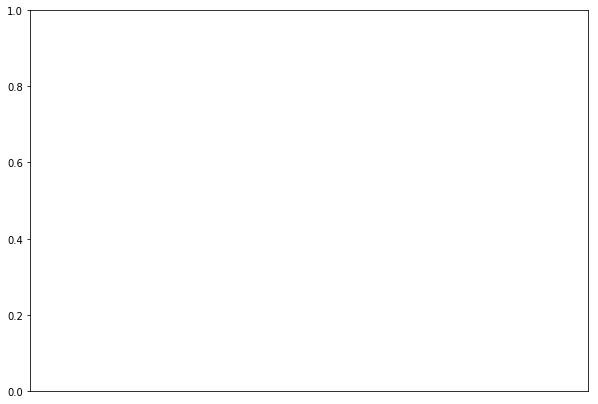

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10,7))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.bar(df2.index, df2['count'])